
# What is the most popular course on DataCamp?

This notebook shows you how to discover the popularity of courses on DataCamp. 

First, we will scrape the data from the website. Then, we load this data into a Pandas DataFrame. In the end, we can find out the most popular course on DataCamp (by technology)!



## 1. Get overview page into BeautifulSoup object

As the amount of participants is only available on the individual course pages, we will first have to scrape all the individual URLs from the overview page. To do this, we will use the Python libraries [requests](http://docs.python-requests.org/en/master/user/quickstart/#make-a-request) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/).


In [1]:
# Import libraries BeautifulSoup & requests
import bs4 
import requests

# URL of the overview page which contains all the links to the individual courses 
overview_url = "https://www.datacamp.com/courses/all"

# Get URL response with the requests library
r = requests.get(overview_url)

# Read content of response
html = r.text

# Create BeautifulSoup object of content to be able to parse HTML page
soup = bs4.BeautifulSoup(html, "lxml")

# Print out object type
type(soup)


bs4.BeautifulSoup


## 2. Get info on individual courses

By looking at the "Page Source" (right mouse click menu or shortcut "CTRL+U") of the overview page, you will see that the HTMLs of all the individual courses look like the code in the cell below. Using BeautifulSoup, we will extract relevant info from the HTML elements, like the URL to the individual course, the type of technology and so on.


In [2]:
# List of all 'div' elements with class 'course-block'
divs = soup.findAll("div", {"class": "course-block "})

# Create empty list for all info of elements
course_info_list = []

# Loop over 'div' elements and extract info by element
for div in divs:
    
    # Upcoming courses don't have statistics, so skip if upcoming
    if div.findAll("div",{"class": "course-block__upcoming"}):
        continue
 
    # Create empty dictionary for info by element
    course_info = {}

    ## Get URL to course & add to dictionary
    # = 'href' attribute of first 'a' element
    # <a class="course-block__link ds-snowplow-link-course-block" href="/courses/free-introduction-to-r">
    url = div.find_next("a").get("href").strip()
    course_info["url"] = "https://www.datacamp.com" + url
    
    ## Get technology of course & add to dictionary
    # = end of text of second 'class' attribute of first 'div' element
    # <div class='course-block__technology course-block__technology--r'></div>
    tech_text = div.find_next("div")["class"][1]
    tech = tech_text[tech_text.find("--")+2:].strip()
    course_info["tech"] = tech
    
    ## Get title of course & add to dictionary
    # = text of first 'h4' element
    # <h4 class="course-block__title">Introduction to R</h4>
    title = div.find_next("h4").text.strip()
    course_info["title"] = title
    
    ## Get description of course & add to dictionary
    # = text of p element with class 'course-block__description'
    # <p class="course-block__description"> Master the basics of data analysis ...and data frames.</p>
    description = div.find_next("p", {"class": "course-block__description"}).text.strip()
    course_info["description"] = description
    
    ## Get author of course & add to dictionary
    # = text of p element with class 'course-block__author-name'
    # <p class="course-block__author-name">Jonathan Cornelissen</p>
    author = div.find_next("p", {"class": "course-block__author-name"}).text.strip()
    course_info["author"] = author
    
    # Add dictionary to list
    course_info_list.append(course_info)
    
    
# Inspect info
print("Number of DataCamp courses : {}".format(len(course_info_list)))
course_info_list[:1]


Number of DataCamp courses : 244


[{'author': 'Jonathan Cornelissen',
  'description': 'Master the basics of data analysis by manipulating common data structures such as vectors, matrices and data frames.',
  'tech': 'r',
  'title': 'Introduction to R',
  'url': 'https://www.datacamp.com/courses/free-introduction-to-r'}]


## 3. Get statistics of individual courses

Information like number of participants and points is only available on the individual course pages and thus will be extracted from there in a likewise manner as above. An example of the HTML page source we are interested in is shown in the cell below.


In [3]:
# ! Because of the 200+ courses, this cell might run for a few minutes or more

# Loop over all courses 
for i,course in enumerate(course_info_list):
    
    # Create BeautifulSoup object of HTML of course page
    html_course = requests.get(course_info_list[i]["url"]).text
    soup_course = bs4.BeautifulSoup(html_course, "lxml")
    
    # Get 'ul' element
    ul = soup_course.find("ul", {"class": "header-hero__stats"})
    
    # Get hours & add to dictionary
    hours = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--hours"}).text.strip()
    course_info_list[i]["hours"] = hours
    
    # Get videos & add to dictionary
    videos = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--videos"}).text.strip()
    course_info_list[i]["videos"] = videos
    
    # Get exercises & add to dictionary
    exercises = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--exercises"}).text.strip()
    course_info_list[i]["exercises"] = exercises
    
    # Get participants & add to dictionary
    participants = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--participants"}).text.strip()
    course_info_list[i]["participants"] = participants
    
    # Get points & add to dictionary
    points = ul.find_next("li", {"class": "header-hero__stat header-hero__stat--xp"}).text.strip()
    course_info_list[i]["points"] = points
    

# Inspect info
course_info_list[:1]


[{'author': 'Jonathan Cornelissen',
  'description': 'Master the basics of data analysis by manipulating common data structures such as vectors, matrices and data frames.',
  'exercises': '62 Exercises',
  'hours': '4 hours',
  'participants': '1,178,124 Participants',
  'points': '6,200 XP',
  'tech': 'r',
  'title': 'Introduction to R',
  'url': 'https://www.datacamp.com/courses/free-introduction-to-r',
  'videos': '0 Videos'}]


## 4. Create Pandas DataFrame

We will create a Pandas DataFrame of the scraped data. As all scraped data is stored as text, we will also do some data cleaning. We will transform the relevant columns (exercises, hours, participants, points & videos) into numerical values, so we are able to aggregate this data. After this last step, we will be able to find the most popular course on DataCamp by technology!


In [4]:
# Import Pandas library
import pandas as pd

# Create DataFrame from list of dictionaries
df_courses = pd.DataFrame(course_info_list) # Yes, it is that easy!

# Inspect DataFrame
df_courses.info() # notice how all columns have data type 'object' (=text)
df_courses.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 10 columns):
author          244 non-null object
description     244 non-null object
exercises       244 non-null object
hours           244 non-null object
participants    244 non-null object
points          244 non-null object
tech            244 non-null object
title           244 non-null object
url             244 non-null object
videos          244 non-null object
dtypes: object(10)
memory usage: 19.1+ KB


,author,description,exercises,hours,participants,points,tech,title,url,videos
0,Jonathan Cornelissen,Master the basics of data analysis by manipula...,62 Exercises,4 hours,"1,178,124 Participants","6,200 XP",r,Introduction to R,https://www.datacamp.com/courses/free-introduc...,0 Videos
1,Matt Dowle,Master core concepts in data manipulation such...,37 Exercises,4 hours,"57,577 Participants","2,900 XP",r,"Data Analysis in R, the data.table Way",https://www.datacamp.com/courses/data-table-da...,10 Videos
2,Garrett Grolemund,Master techniques for data manipulation using ...,42 Exercises,4 hours,"99,400 Participants","3,400 XP",r,Data Manipulation in R with dplyr,https://www.datacamp.com/courses/dplyr-data-ma...,11 Videos
3,Garrett Grolemund,Learn to create interactive graphs to display ...,45 Exercises,4 hours,"40,855 Participants","3,700 XP",r,Data Visualization in R with ggvis,https://www.datacamp.com/courses/ggvis-data-vi...,11 Videos
4,Garrett Grolemund,Learn to create interactive analyses and autom...,31 Exercises,3 hours,"61,493 Participants","2,550 XP",r,Reporting with R Markdown,https://www.datacamp.com/courses/reporting-wit...,8 Videos


In [5]:
# Create function to extract the numerical value from text
def GetNumericalValue(text):
    
    """
    Notice how the numerical value is always the first group of characters:
    '62 Exercises', '4 hours', '1,171,673 Participants', '6,200 XP', 0 Videos'

    Example of transformation:
    
    text = "6,200 XP"
    text.split() = ["6,200", "XP"]  # split() by default on spaces
    text.split()[0] = "6,200"  # first element
    text.split()[0].replace (',','') = "6200"  # remove comma, still data type str
    int(text.split()[0].replace(',','')) = 6200  # data type int
    """
    
    # Split text, take first block of characters, remove comma's & change data type to integer
    return int(text.split()[0].replace(',',''))


# Transform columns with numerical values
df_courses["exercises"] = df_courses["exercises"].apply(lambda x : GetNumericalValue(x))
df_courses["hours"] = df_courses["hours"].apply(lambda x : GetNumericalValue(x))
df_courses["participants"] = df_courses["participants"].apply(lambda x : GetNumericalValue(x))
df_courses["points"] = df_courses["points"].apply(lambda x : GetNumericalValue(x))
df_courses["videos"] = df_courses["videos"].apply(lambda x : GetNumericalValue(x))
    
# Inspect DataFrame (after transformations)
df_courses.info() # notice how the above columns changed to data type 'int64' (=integer)
df_courses.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 10 columns):
author          244 non-null object
description     244 non-null object
exercises       244 non-null int64
hours           244 non-null int64
participants    244 non-null int64
points          244 non-null int64
tech            244 non-null object
title           244 non-null object
url             244 non-null object
videos          244 non-null int64
dtypes: int64(5), object(5)
memory usage: 19.1+ KB


,author,description,exercises,hours,participants,points,tech,title,url,videos
0,Jonathan Cornelissen,Master the basics of data analysis by manipula...,62,4,1178124,6200,r,Introduction to R,https://www.datacamp.com/courses/free-introduc...,0
1,Matt Dowle,Master core concepts in data manipulation such...,37,4,57577,2900,r,"Data Analysis in R, the data.table Way",https://www.datacamp.com/courses/data-table-da...,10
2,Garrett Grolemund,Master techniques for data manipulation using ...,42,4,99400,3400,r,Data Manipulation in R with dplyr,https://www.datacamp.com/courses/dplyr-data-ma...,11
3,Garrett Grolemund,Learn to create interactive graphs to display ...,45,4,40855,3700,r,Data Visualization in R with ggvis,https://www.datacamp.com/courses/ggvis-data-vi...,11
4,Garrett Grolemund,Learn to create interactive analyses and autom...,31,3,61493,2550,r,Reporting with R Markdown,https://www.datacamp.com/courses/reporting-wit...,8



## 5. Find out what the most popular course / technology / author / ... is on DataCamp!

We can use the clean DataFrame to find out what we want about DataCamp courses. The cells below will show you some interesting facts. What else would you like to know about this? Have fun playing around!


In [6]:
# Create DataFrame for outputting results
df_results = df_courses[["title","tech","participants","author","points","exercises","videos","hours"]]

# The most popular course on DataCamp
df_results.sort_values("participants", ascending=False).head()

# As of March 2019, the Introduction to Python course is the most popular on DataCamp!


,title,tech,participants,author,points,exercises,videos,hours
8,Introduction to Python,python,1372903,Filip Schouwenaars,4700,57,11,4
0,Introduction to R,r,1178124,Jonathan Cornelissen,6200,62,0,4
12,Intermediate Python for Data Science,python,317110,Filip Schouwenaars,7400,87,18,4
5,Intermediate R,r,299606,Filip Schouwenaars,6950,81,14,6
57,Intro to SQL for Data Science,sql,265869,Nick Carchedi,3450,41,1,4


In [7]:
# The most popular technology on DataCamp by participants
df_results.groupby("tech").sum().sort_values("participants", ascending=False)

# Despite Python having the most popular course, R courses have more participants in total!


,participants,points,exercises,videos,hours
tech,,,,,
r,3321208,633551,7911,2149,599
python,3083762,335500,4126,1140,307
sql,350928,37750,455,116,37
git,50744,3350,46,0,4
spreadsheets,42678,27000,313,69,25
shell,26034,6300,111,0,10


In [8]:
# The most popular author on DataCamp by participants
df_results.groupby("author").sum().sort_values("participants", ascending=False).head()

# No surprise by looking at the most popular courses, Filip Schouwenaars is the most popular author on DataCamp!


,participants,points,exercises,videos,hours
author,,,,,
Filip Schouwenaars,2159690,31350,367,64,24
Jonathan Cornelissen,1178124,6200,62,0,4
Hugo Bowne-Anderson,431658,18200,229,63,16
Nick Carchedi,378761,11700,135,17,12
Garrett Grolemund,262573,23500,348,103,21


In [9]:
# The most popular technology on DataCamp by number of courses
df_results[["tech","title"]].groupby("tech").count().sort_values("title", ascending=False)

# The amount of R courses on DataCamp is almost twice as high as the Python courses!


,title
tech,
r,147
python,77
sql,9
spreadsheets,7
shell,3
git,1


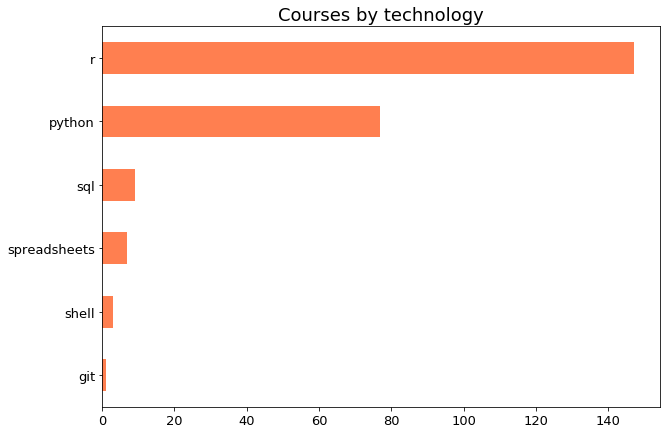

In [10]:
# Visualize number of courses by technology with Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Horizontal bar chart
ax = df_results["tech"].value_counts().plot(kind="barh", figsize=(10,7), color="coral", fontsize=13)
ax.set_title("Courses by technology", fontsize=18)
ax.invert_yaxis() # highest on top


              title  participants    avg
tech                                    
git               1         50744  50744
python           77       3083762  40048
sql               9        350928  38992
r               147       3321208  22593
shell             3         26034   8678
spreadsheets      7         42678   6096


Text(0.5,1,'Average Participants by course')

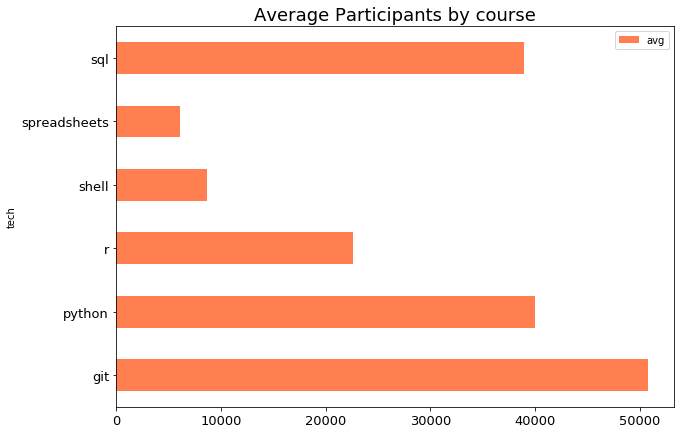

In [11]:
# Get the average amount of participants by course

# Get amount of participants by technology
df_participants = df_results[["tech","participants"]].groupby("tech").sum()

# Get amount of courses by technology
df_counts = df_results[["tech","title"]].groupby("tech").count()

# Join DataFrames
df_join = df_counts.join(df_participants)
df_join["avg"] = (df_join["participants"] / df_join["title"]).astype(int)

# Show table
print(df_join.sort_values("avg", ascending=False))

# Show barchart
rx = df_join[["avg"]].plot(kind="barh", figsize=(10,7), color="coral", fontsize=13)
rx.set_title("Average Participants by course", fontsize=18)

# Based on average participants by course, Git & SQL courses are actually more popular than Python or R courses!
